<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/wine_segmentation_v_0_0_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [ ]:
# Install segmentation models package
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=aa68b1fddab1d163f50c042fd23a9fb8bb9f0837e5cf54bc10da8fa49b235d3b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a7e31542087fef0c212b9eb4b0f381b73c2183bf2c722ec72dbc4887cb2d8e25
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
pip install segments-ai

# Download Dataset

I will be using an open source dataset for this task which is available on GitHub. The dataset contains images of humans in different environments and settings and their corresponding masks. The masks can be thought of as the outline of the humans/objects in the image and helps to identify their positions in the image separating them from the background.

Credits for the dataset goes to [Vikram Shenoy](https://github.com/VikramShenoy97/Human-Segmentation-Dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Загрузка датасета из segments.ai (свернуть)

In [ ]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset

# Initialize a SegmentsDataset from the release file
client = SegmentsClient('7d4e830aad20725decd837320b15caaae0ac1bbe')
release = client.get_release('tynshun/wineyard', 'v0.0.4') # Alternatively: release = 'flowers-v1.0.json'
dataset = SegmentsDataset(release, labelset='ground-truth', filter_by=['labeled', 'reviewed'])

# Export to COCO panoptic format
export_dataset(dataset, export_format='coco-panoptic')

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 113/113 [00:05<00:00, 19.49it/s]


Initialized dataset with 113 images.
Exporting dataset. This may take a while...


100%|██████████| 113/113 [00:03<00:00, 35.74it/s]


Exported to ./export_coco-panoptic_tynshun_wineyard_v0.0.4.json. Images and labels in segments/tynshun_wineyard/v0.0.4


('./export_coco-panoptic_tynshun_wineyard_v0.0.4.json',
 'segments/tynshun_wineyard/v0.0.4')

# Import libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt

import torch

import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Setup Configurations

In this step I would define the different paths, hyperparameters, models and weights which I will be using later in the notebook.

In [ ]:
# Define path variables
TRAIN_DATA_PATH = '/content/drive/MyDrive/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'
DATA_DIR = '/content/drive/MyDrive/tynshun_wineyard_coco_panoptic/v.0.1/'

train_dir = '/'
test_dir = '/'

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size

# Define pretrained encoder model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

# Load Data and Find classes
!! ты поменяла имена столбцов
функции вывода рабоать не будут


In [ ]:
def get_df_images_masks(path_to_coco, path_to_dir):
  # Загрузка JSON-файла аннотаций COCO
  with open(path_to_coco, 'r') as f:
    coco_data = json.load(f)
  df_images = pd.DataFrame(coco_data['images'])
  df_images['file_name'] = df_images['file_name'].apply(lambda x: path_to_dir + x)
  df_images.rename(columns={'id': 'image_id'}, inplace=True)
  df_annotations = pd.DataFrame(coco_data['annotations'])
  df_annotations['file_name'] = df_annotations['file_name'].apply(lambda x: path_to_dir + x)
  # Склеивание DataFrame по столбцу 'id'
  merged_df = pd.merge(df_images, df_annotations, on='image_id')
  merged_df.rename(columns={'file_name_x': 'images'}, inplace=True)
  merged_df.rename(columns={'file_name_y': 'masks'}, inplace=True)
  return merged_df

In [ ]:
df = get_df_images_masks(TRAIN_DATA_PATH, DATA_DIR)
df.head()
print(df.shape)

(113, 6)


Функция по поиску классов сегментации

In [ ]:
def find_classes(directory: str): # указать возвращаемый тип данных
    # дописать многострочный комментарий
    with open(directory, 'r') as f:
      data_json = json.load(f)
    type(data_json['categories'])
    classes = [cat['name'] for cat in data_json['categories']]
    classes_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, classes_idx

The dataframe consists of images and their corresponding masks. Let's see some of the sample images and masks.

# Explore the Data

In [ ]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]# выберем 5 случайных индексов из нашего df

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0 #перевод в серую шкалу и нормализация! ВАУ!

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

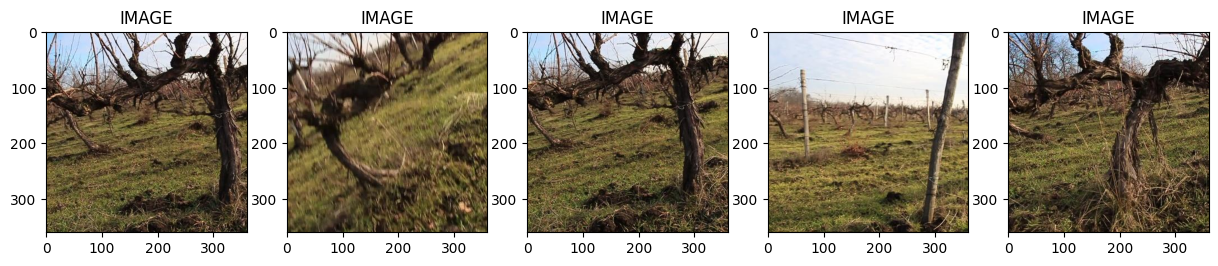

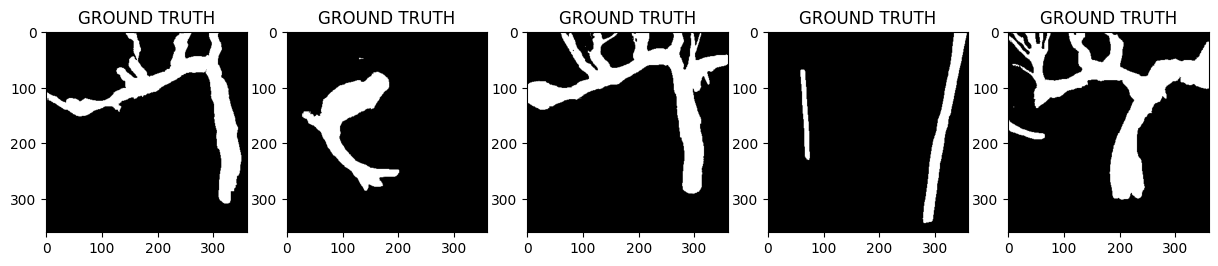

In [ ]:
generate_sample_images(sample)
generate_sample_masks(sample)

# Split the Data

Let's split our data into training and validation sets before training the model.

In [ ]:
# Split data in separate train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

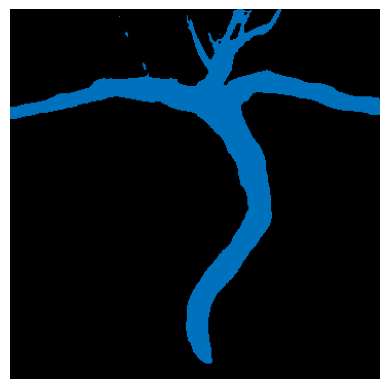

/content/segments/tynshun_wineyard/v0.0.4/frame_15427_label_ground-truth_coco-panoptic.png


In [ ]:
def show_image_from_df(image_path):
  image = cv2.imread(image_path)
  # Отображение изображения
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

image_path = train_df.iloc[0]['masks']
show_image_from_df(image_path)
print(image_path)


# Data Augmentation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

## Свернуть

In [ ]:
import albumentations as A

In [ ]:
# Define the augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        #A.HorizontalFlip(p=0.5),      # Horizontal Flip with 0.5 probability
        #A.VerticalFlip(p=0.5)         # Vertical Flip with 0.5 probability
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

# Processing the Dataset

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

здесь я хочу переписать его следующим образом... вместо targ_dir сделать df и с ним работать также как и в v0.0.1

In [ ]:
class ImageFolderCustom(Dataset):
    def __init__(self, df, targ_dir, transform=None, grayscale = False) -> None:
        # Упростили по сравнению с прошлой версией кода
        self.df = df
        self.transform = transform
        self.grayscale = grayscale
        # Попробуем создать вывод классов
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def __len__(self) -> int:
        return len(self.df)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int): # -> Tuple[torch.Tensor, int]:

        sample = self.df.iloc[index]
        image = sample.images # путь к файлу изобржания
        mask = sample.masks # путь к файлу маски

        # Чтение images and masks. МБ ФУНКЦИЕЙ  def load_image(self, index: int) -> Image.Image:
        image = Image.open(image)
        mask = Image.open(mask)
        #image = cv2.imread(image)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        #mask = np.expand_dims(mask, axis=-1)
        if self.grayscale:
            image = Image.open(image).convert("L")
            mask = Image.open(mask).convert("L")
        else:
            image = Image.open(image).convert("RGB")
            mask = Image.open(mask).convert("RGB")
        # Применяем трансформацию
        if self.transform:
            return self.transform(image), self.transform(mask) # return transform data, label (X, y)
        else:
            return image, mask # return data, label (X, y)

In [ ]:
train_data_custom = ImageFolderCustom(df=train_df, targ_dir=TRAIN_DATA_PATH, transform=train_transforms)
test_data_custom = ImageFolderCustom(df=val_df, targ_dir=TRAIN_DATA_PATH, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a9ac7c7b520>,
 <__main__.ImageFolderCustom at 0x7a9ac7c7b8e0>)

In [ ]:
train_data_custom.classes

['wine', 'post']

In [ ]:
# Check the lengths
len(train_data_custom), len(test_data_custom)

(90, 23)

In [ ]:
train_data_custom[0]

(tensor([[[0.6275, 0.6118, 0.5882,  ..., 0.9725, 0.9686, 0.9686],
          [0.6275, 0.6078, 0.5843,  ..., 0.9765, 0.9765, 0.9725],
          [0.6275, 0.6078, 0.5843,  ..., 0.9804, 0.9765, 0.9765],
          ...,
          [0.2235, 0.2314, 0.2196,  ..., 0.2588, 0.2784, 0.2471],
          [0.2706, 0.2667, 0.2353,  ..., 0.2667, 0.2471, 0.1804],
          [0.3373, 0.3176, 0.2627,  ..., 0.3647, 0.3294, 0.1686]],
 
         [[0.7882, 0.7961, 0.8039,  ..., 0.9725, 0.9686, 0.9686],
          [0.7882, 0.8000, 0.8078,  ..., 0.9765, 0.9725, 0.9725],
          [0.7922, 0.8000, 0.8078,  ..., 0.9765, 0.9725, 0.9725],
          ...,
          [0.1490, 0.1569, 0.1451,  ..., 0.2000, 0.2196, 0.1882],
          [0.1961, 0.1922, 0.1608,  ..., 0.2196, 0.1961, 0.1333],
          [0.2627, 0.2431, 0.1882,  ..., 0.3216, 0.2863, 0.1255]],
 
         [[0.9922, 1.0000, 1.0000,  ..., 0.9804, 0.9804, 0.9765],
          [0.9922, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9843],
          [0.9882, 1.0000, 1.0000,  ...,

In [ ]:
img, label = train_data_custom[0][0], train_data_custom[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

## Свернуть

In [ ]:
# Create a custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images # путь к файлу изобржания
        mask = sample.masks # путь к файлу маски

        # Read images and masks
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        #print(f"Shapes of images before augmentation: {image.shape}")
        #print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        #print(f"\nShapes of images after augmentation: {image.shape}")
        #print(f"Shapes of masks after augmentation: {mask.shape}")

        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # Normalize the images and masks
        image = torch.Tensor(image) / 255.0
        #mask = torch.round(torch.Tensor(mask) / 255.0)
        mask = (torch.Tensor(mask) > 0).float()

        return image, mask

In [ ]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [ ]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 90
Size of Validset : 23


In [ ]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()

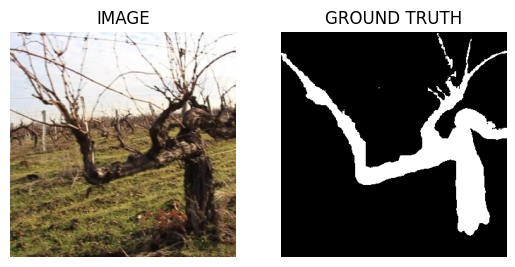

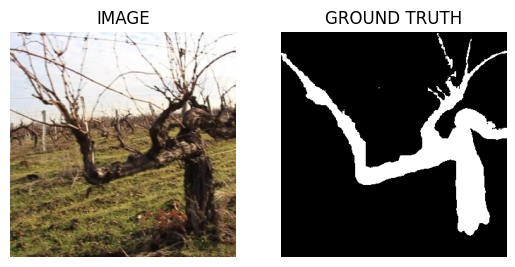

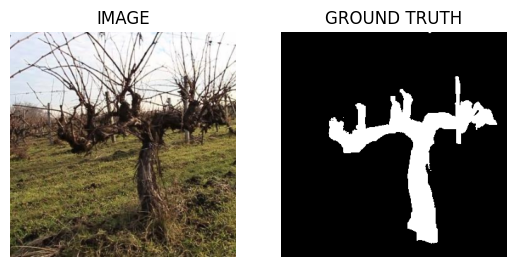

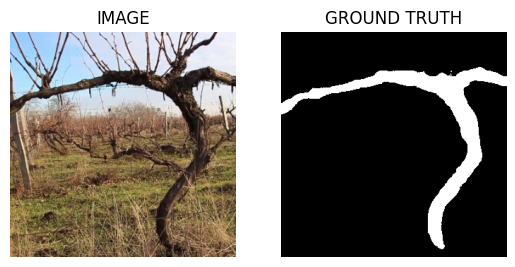

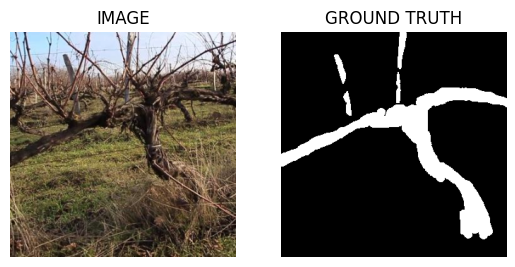

In [ ]:
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

# Display sample random images

In [ ]:
import random

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  dataset = train_data_custom
  if n > 10:
      n = 10
      display_shape = False
      print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  if seed:
      random.seed(seed)

  random_array = np.random.randint(0, len(dataset), n)

  plt.figure(figsize=(16, 8))
  for i, idx in enumerate(random_array):
    image, mask = dataset[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.title("IMAGE")

    plt.subplot(2, 5, i+6)
    plt.imshow(np.transpose(mask, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH")

  plt.tight_layout()
  plt.show()

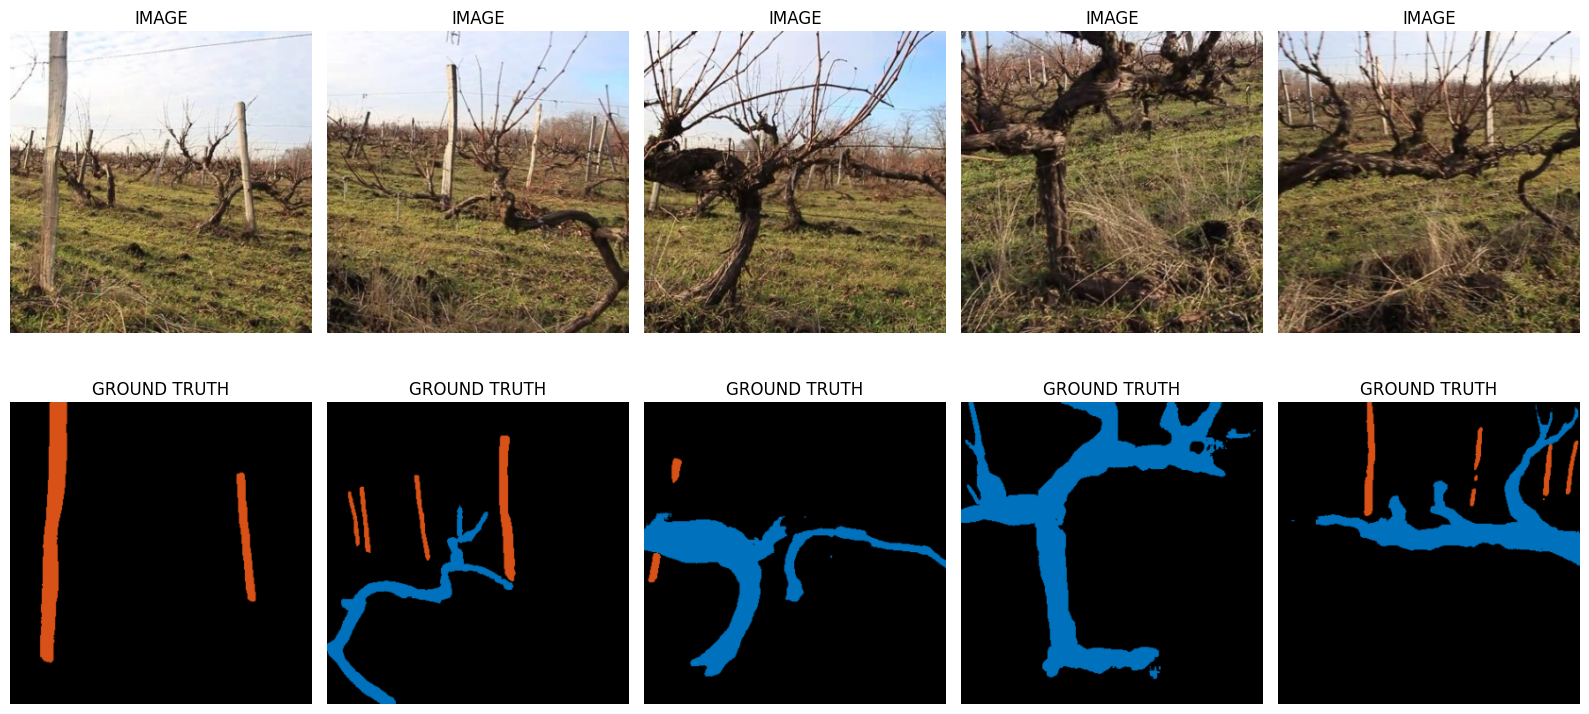

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=train_data_custom.classes,
                      seed=None)

# Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 3
Total number of batches in Val Loader: 1


In [ ]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 3, 320, 320])
Size of one batch of masks: torch.Size([32, 3, 320, 320])


# Create Segmentation Model

There are many CNN model architectures present in the pytorch's segmentation models documentation that can be used but for this project I will use Unet++ architecture. [Unet++](https://arxiv.org/abs/1807.10165) is a fully convolutional neural network for image semantic segmentation. It consists of encoder and decoder parts connected with skip connections. The encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation masks. It uses concatenation for fusing decoder blocks with skip connections.

**Documentation**: https://segmentation-models-pytorch.readthedocs.io/en/latest/models.html#id2

![UNet++ architecture](https://pic.imgdb.cn/item/60dac54e5132923bf81d4a25.jpg)

I will now create the Segmentation model using the Unet++ architecture. The parameters used for the model are:
- **Efficient Net** is used as the encoder model
- Weights used are of **Imagenet**
- Input channels are 3 due to **RGB** images

In the forward method I defined the loss functions. DiceLoss and Binary Cross Entropy are used as loss functions for this task.

[Dice loss](https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.) is a metric commonly used to evaluate the performance of machine learning models in image segmentation tasks. It is a measure of the dissimilarity between the predicted segmentation (mask) and the true segmentation of an image.

In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 127MB/s] 


The above output displays the full architecture of the UNet++. We have downloaded the model successfully. Now it's time to train it.

# Create Train and Validation Function

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a train() function to combine train_step() and test_step()

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=DEVICE)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=DEVICE)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Свернуть

In [ ]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

# Model Training

Before training the model make sure that your GPU is running because it would take eternity to train the model on a CPU.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Setup loss function
loss_fn = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [ ]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Set number of epochs
NUM_EPOCHS = 5

# Train model_0
model_0_results = train(model=model,
                        train_dataloader=trainloader,
                        test_dataloader=valloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

### Свернуть

In [ ]:
# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.8495921691258748 Val Loss 21.304431915283203


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


MODEL SAVED
 Epoch 2 Train Loss 1.4448322455088298 Val Loss 18.442495346069336


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


MODEL SAVED
 Epoch 3 Train Loss 1.2200347185134888 Val Loss 7.243044853210449


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


MODEL SAVED
 Epoch 4 Train Loss 1.0779677232106526 Val Loss 2.373652935028076


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


MODEL SAVED
 Epoch 5 Train Loss 0.9761701623598734 Val Loss 1.5029699802398682


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


MODEL SAVED
 Epoch 6 Train Loss 0.8946224053700765 Val Loss 1.2692022323608398


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


MODEL SAVED
 Epoch 7 Train Loss 0.8246417244275411 Val Loss 1.1028013229370117


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


MODEL SAVED
 Epoch 8 Train Loss 0.7608984708786011 Val Loss 0.8813999891281128


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


MODEL SAVED
 Epoch 9 Train Loss 0.7007198532422384 Val Loss 0.7320830821990967


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

MODEL SAVED
 Epoch 10 Train Loss 0.6360635956128439 Val Loss 0.6534358859062195


In only 10 epochs the model reduced the validation loss to close to 0.2 which is very good. THis shows the power of the Unet architecture on Image segmentation preoblems. Now let's see how our model predictions look in comparison to the original masks.

# Inference

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

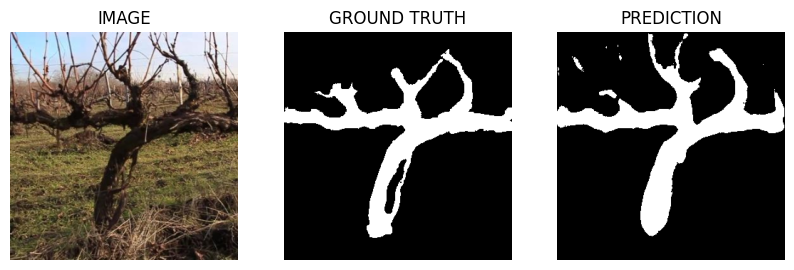

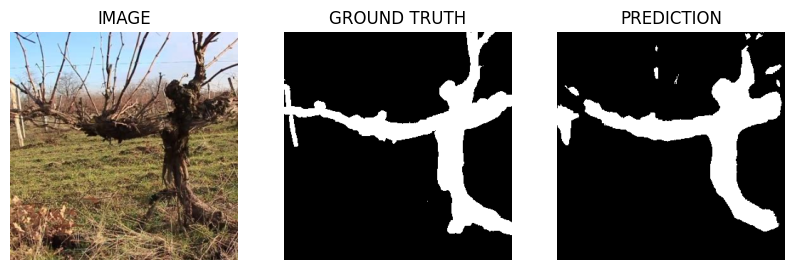

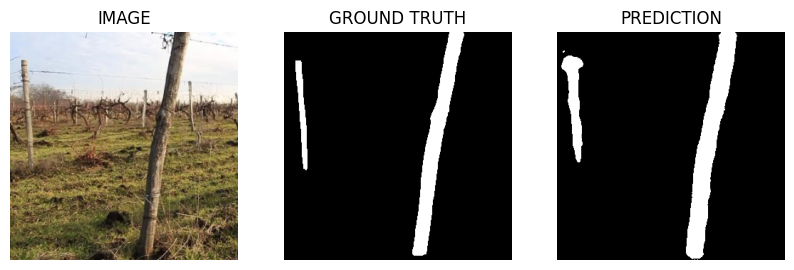

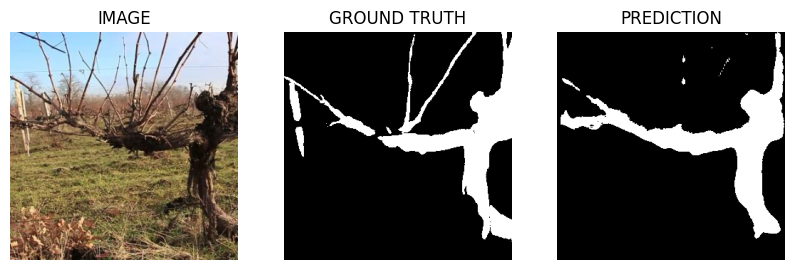

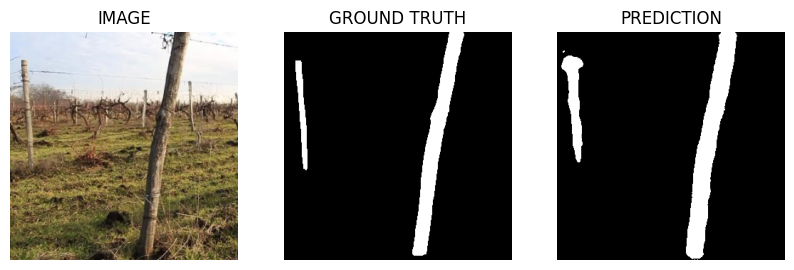

In [ ]:
# Compare predictions with original
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.

**Consider giving an upvote👍 if you liked the notebook. It will help it to reach a wider audience.**

**It would be highly appreciated if you can take out some time to share your views on what you liked in the notebook and what can be the potential improvements that can be made to further improve the notebook.**

**Thanks**

# References

- **Notebook inspired from this project**: https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation
- **Image Segmentation**: https://www.ibm.com/topics/image-segmentation
- **albumentations documentation**: https://albumentations.ai/docs/
- **segmentation_models_pytorch documentation**: https://smp.readthedocs.io/en/latest/
- **Unet++ original paper**: https://arxiv.org/abs/1807.10165
- **Dice Loss**: https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.

In [ ]:
torch.cuda.empty_cache()